In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm

from scipy import ndimage as ndi
from scipy.spatial import distance

from skimage import io
from skimage.color import rgb2gray
from skimage import filters
from skimage.morphology import disk

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2

from grain_utils import grainPreprocess,grainShow,grainMark,grainDraw


In [2]:
grain1_name='Ultra_Co6_2-040.jpg'
grain2_name='Ultra_Co11-2.jpg'
grain3_name='Ultra_Co25-1.jpg'

path='images'

grain1_pil=Image.open(path+'/'+grain1_name)
grain2_pil=Image.open(path+'/'+grain2_name)
grain3_pil=Image.open(path+'/'+grain3_name)
image=grainPreprocess.image_preprocess(grain2_pil)

D:\PROJECTS\python\grain_segmentation\grain_utils.py:44: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image=rgb2gray(img)


In [ ]:
img_show(image2,cmap='gray')

## Маркировка углов

In [3]:
corners2,classes2,classes2_num=grainMark.mark_corners_and_classes(image)

## Дадим каждой вершине привязку к пустоте

In [4]:
nodes2, classes2,classes2_num,corners2=grainMark.get_nodes_corners_classes_classesNum(image,100)

## Подсчитаем количество пустот, в которые входит угол

std:  0.0
mean:  1.0
количество пустот:  343


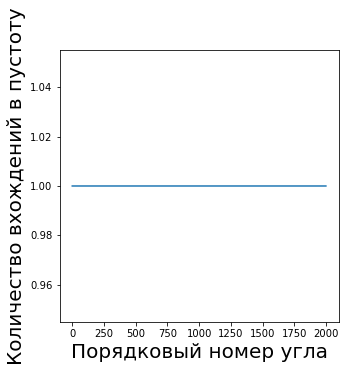

array([1., 1., 1., ..., 1., 1., 1.])

In [5]:
grainShow.classes_corners(nodes2,corners2,show=True)


## Подсчитаем количество углов у пустот

std:  4.009
mean:  1.111
количесвто углов:  3036


array([[28.],
       [ 0.],
       [ 0.],
       ...,
       [ 0.],
       [ 0.],
       [ 0.]])

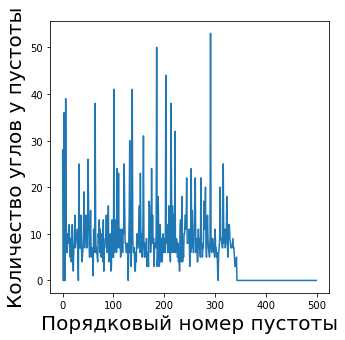

In [6]:
grainShow.corners_classes(nodes2,corners2,max_num=500,show=True)

## Соединим углы пустоты по периметру

In [8]:

radius=6
eps=0.1


new_nodes2=grainMark.sort_perimetr(image,nodes2,corners2,eps,radius)

img=grainDraw.draw_edges(image,new_nodes[2:50],grain2_corners)
grainShow.img_show(img,cmap='gray',N=12)
name='vals.png'
io.imsave(name,img)

NameError: name 'image2' is not defined

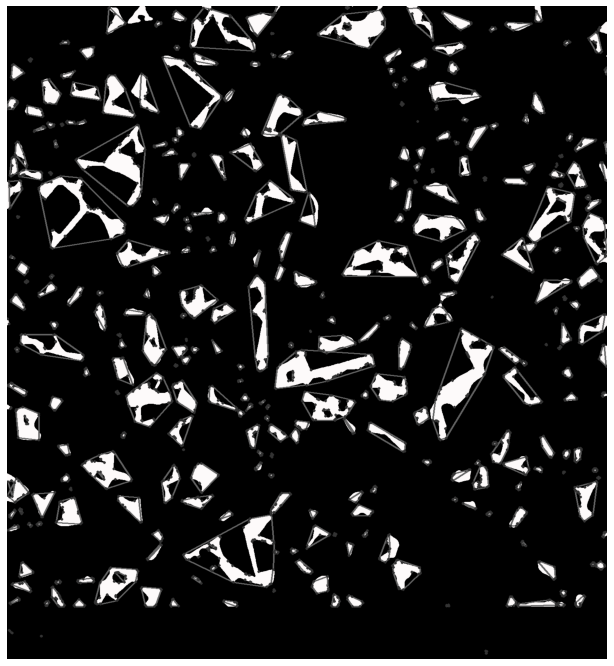

In [9]:
img=grainDraw.draw_edges_hull(image,nodes2[2:],corners2)
grainShow.img_show(img,cmap='gray',N=12)
name='valsh.png'
io.imsave(name,img)